# exam of Introduction to Machine Learning

The goal of this exam is perform an analysis on data related to heart disease,
in particular, we want to explore the relationship between a `target` variable - whether patient has a heart disease or not - and several other variables such as cholesterol level, age, ...

The data is present in the file `'heartData_simplified.csv'`, which is a cleaned and simplified version of the [UCI heart disease data set](https://archive.ics.uci.edu/ml/datasets/heart+Disease)



## description of the columns

* age : Patient age in years
* sex : Patient sex
* chol : Cholesterol level in mg/dl. 
* thalach : Maxium heart rate during the stress test
* oldpeak : Decrease of the ST segment during exercise according to the same one on rest.
* ca : Number of main blood vessels coloured by the radioactive dye. The number varies between 0 to 3.
* thal : Results of the blood flow observed via the radioactive dye.
	* defect -> fixed defect (no blood flow in some part of the heart)
	* normal -> normal blood flow
	* reversible -> reversible defect (a blood flow is observed but it is not normal)
* target : Whether the patient has a heart disease or not

**code to read the data**

In [2]:
import pandas as pd

df = pd.read_table('heartData_simplified.csv',sep=',')
df.head()
print(len(df))

296


You can see that we have to handle categorical variables : `sex` , `thal`, and our response variable : `target`.

If taken as-is, they make create problems in models. 
So we will first transform them to sets of 0/1 columns :

In [3]:
# in this first line, I make sure that "normal" becomes the default value for the thal columns
df['thal'] = df['thal'].astype(pd.CategoricalDtype(categories=["normal", "reversible", "defect"],ordered=True))

# get dummies will transform these categorical columns to sets of 0/1 columns
df = pd.get_dummies( df , drop_first=True )

df.head()

,age,chol,thalach,oldpeak,ca,sex_male,thal_reversible,thal_defect,target_yes
0,63,233,150,2.3,0,True,False,True,False
1,37,250,187,3.5,0,True,False,False,False
2,41,204,172,1.4,0,False,False,False,False
3,56,236,178,0.8,0,True,False,False,False
4,57,354,163,0.6,0,False,False,False,False


So now, we can see that `sex` has been replaced by `sex_male`, a column where 1 means male, and 0 means female (so female is the default value, and in subsequent models, the parameter associated with this column will represent to effect associated with being male).

Similarly, `target` has been replaced with `target_yes` : 0 means no heart disease, 1 means presence of heart disease.

Finally, `thal` has actualy been replace by 2 columns: this is how categorical variables with more than 2 levels are represented. A 1 in one of these to column means that the blood flow is reversible of fixed (depending on which column the 1 is).
When `thal_reversible` and `thal_defect` are at 0, it means that blood flow is normal, the "default" value (note that there is no case when they are both 1).


**Instructions**

Your mission is to implement a machine learning pipeline in order to predict `target_yes`.

Try to choose a relevant approach regarding :
 * the split of your data into train and test sets
 * the metric you would like to optimize


Try a logistic regression and a decision tree approach.
 * Which one yields the best result here ?
 * If you had to remove 3 measurements out of this analysis, which one would you use?
 * try to describe briefly (in 3 or 4 sentences) which insights your model could yield about the relationship betwen heart disease and the coraviables.



In [4]:
coVariables = df.drop('target_yes' , axis=1)
response = df.target_yes

In [5]:
print('fraction of observation with the heart disease (ie. target variable) :',df.target_yes.mean())

fraction of observation with the heart disease (ie. target variable) : 0.4594594594594595


So the data appears to have a slight imbalance. 
We will be sure to stratify the split  intro train and test set by the response variable to ensure that this imbalanced is represented in each case.


**Data leakage** is a very dangerous and insidious pitfall when performing machine learning.
It occurs whenever we inform our process of building our classifier with data coming from the test set.

In order to avoid it, let's separate train and test set early. We will not touch the test set until the very end of the analysis.

## train / test separation

In [6]:
from sklearn.model_selection import train_test_split

SEED = 2023

#split your data

X_train, X_test, y_train, y_test = train_test_split( coVariables , response  , 
                                                    random_state= SEED  ,stratify= response )
# stratify is here to make sure that you split keeping the repartition of labels unaffected
# by default, the data is split such that 75% is in the train set and 25% in the test set 
print('train set size' , len(y_train))
print('test set size' , len(y_test))
print("fraction of class 'yes' in train",sum(y_train)/len(y_train))
print("fraction of class 'yes' in test",sum(y_test)/len(y_test) )
print("fraction of class 'yes' in full",sum(response)/len(response))

train set size 222
test set size 74
fraction of class 'yes' in train 0.4594594594594595
fraction of class 'yes' in test 0.4594594594594595
fraction of class 'yes' in full 0.4594594594594595


In [7]:
df.columns

Index(['age', 'chol', 'thalach', 'oldpeak', 'ca', 'sex_male',
       'thal_reversible', 'thal_defect', 'target_yes'],
      dtype='object')

## plotting features to gain a feeling for them

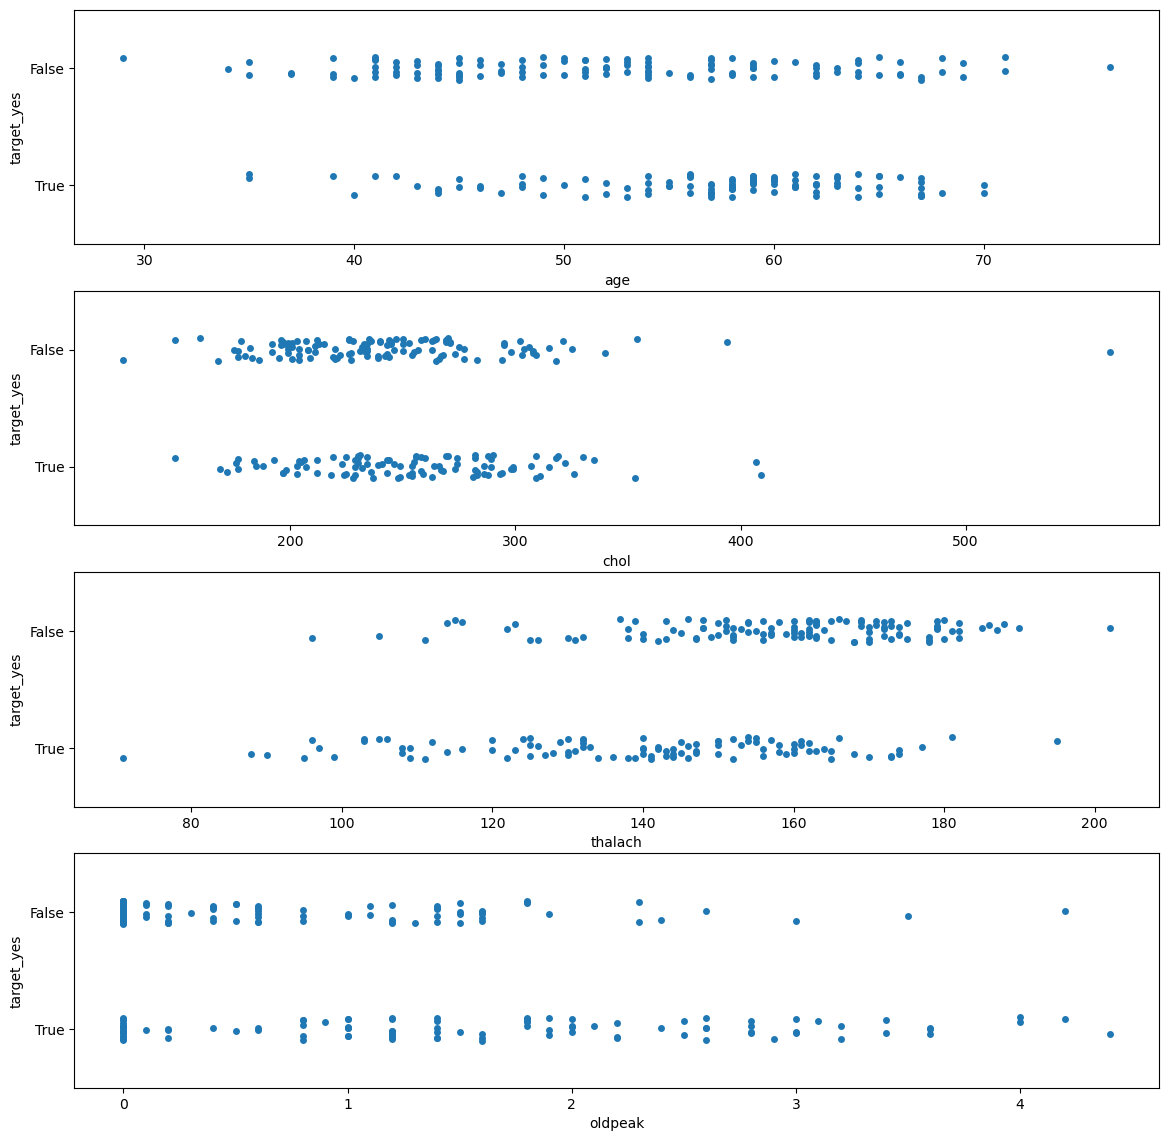

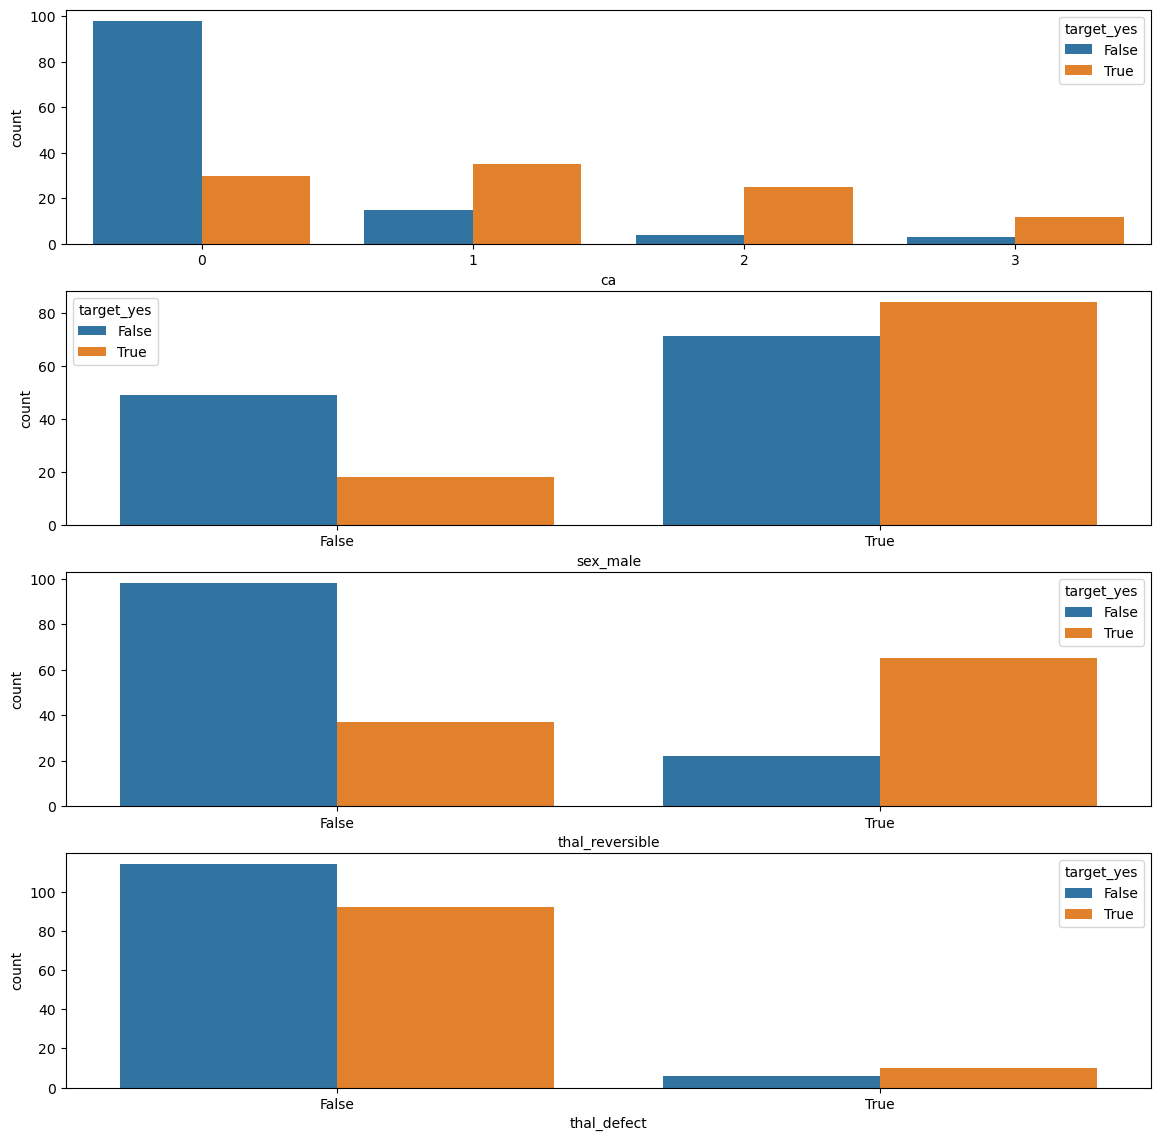

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

#fig,ax = plt.subplots( len( coVariables.columns ) , figsize = (16,10) )

scatterVar = ['age' , 'chol' , 'thalach' , 'oldpeak']
catVar = [ 'ca' , 'sex_male' , 'thal_reversible' , 'thal_defect' ]

fig,ax = plt.subplots( len(scatterVar),1 , figsize=(14,3.5*len(catVar)) )
for i, col in enumerate( scatterVar ) : 
    sns.stripplot( x = X_train[col] , y = y_train , ax = ax[i] , orient = 'h' )


fig,ax = plt.subplots( len(catVar),1 , figsize=(14,3.5*len(catVar)) )
for i , col in enumerate( catVar ) :
    sns.countplot(x= X_train[col], hue=y_train , ax =ax[i])



Let's now look at the correlation between features:

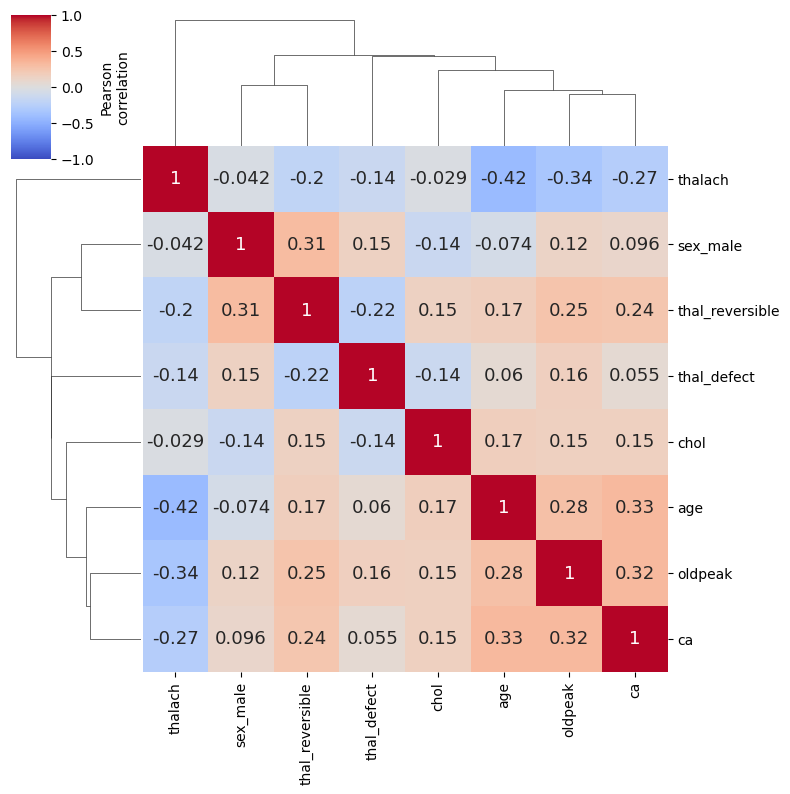

In [9]:
# check for correlations
import matplotlib.pyplot as plt
df_corr = X_train.corr()

sns.clustermap(df_corr,
               figsize=(8,8),
               z_score=None,
               row_cluster=True,
               col_cluster=True,
               method='ward',
               cmap='coolwarm',vmax=1,vmin=-1, 
               annot=True, annot_kws={"size": 13},cbar_kws={"label": 'Pearson\ncorrelation'})

plt.show()

There is no features which seems extremely correlated.

### choosing a metric

Then we need to choose which metrics we will use to evaluate our different models.

Here, there is a slight imbalance between the two classes, but, more importantly, 
we may not want to treat false positive and true positive in the same way: indeed we could prefer to have less false negative (ie. people with an undiagnosted heart disease) at the cost of having more false positive (ie. people spuriously diagnosed with a heart disease).
So given this we will use the ROC AUC (area under the ROC) as a metric rather than accuracy.

Also, at some point there will need to be some balancing between the fraction of False Positive and False Negative, which can be visualized using either the ROC or the precision-recall curve.

# logisitic classifier

let's first create a couple of helper functions:

In [16]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import scipy as sc
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix


## let's make a helper function to plot the roc 
def makeROCplot( X , y , decFun , ax , dt = 0.5 , applyExpit = True):
    """
        * X : features
        * y : target
        * decFun : decision function of the model
        * ax : maplotlib ax to plot
        * dt = 0.5 : decision threshold to show (default 0.5), can be al ist of threshold
        * applyExpit = True : whether to apply the expit transform to thresholds (eg. for logistic regression)
    """
    
    # 1. decision_function gives you the proba for a point to be in a class
    y_score_lr_c = decFun(X)
    # 2. this calculates the ROC curve
    fpr_lr_c, tpr_lr_c, thre = roc_curve(y, y_score_lr_c)
    if applyExpit:
        thre = sc.special.expit(thre)
    # 3. finally this calculates the area under the curve
    roc_auc_lr_c = auc(fpr_lr_c, tpr_lr_c)
    #print("Area under the ROC curve",roc_auc_lr_c)

    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    ax.plot(fpr_lr_c, tpr_lr_c, lw=3, label='ROC curve\n (area = {:0.3f})'.format(roc_auc_lr_c))
    
    #this part is just to check where your probability threshold sits on the roc curve
    if isinstance(dt,float):
        dt = [dt]

    for x in dt:
        keep = np.argmin( np.abs(thre - x ) )
        ax.plot(fpr_lr_c[keep], tpr_lr_c[keep], marker='o' , linewidth = 0 ,label='threshold='+str(x))
        
    
    ax.set_xlabel('False Positive Rate', fontsize=16)
    ax.set_ylabel('True Positive Rate', fontsize=16)

    ax.legend(loc='lower right', fontsize=13)
    ax.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    ax.set_aspect('equal')
    return ax

In [17]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

## let's make a helper function to plot the precision recall curve
def makePRplot( X , y , decFun , ax , dt = 0.5 , applyExpit = True):
    """
        * X : features
        * y : target
        * decFun : decision function of the model
        * ax : maplotlib ax to plot
        * dt = 0.5 : decision threshold to show (default 0.5), can be al ist of threshold
        * applyExpit = True : whether to apply the expit transform to thresholds (eg. for logistic regression)
    """
    
    # 1. decision_function gives you the proba for a point to be in a class
    probas = decFun(X)
    # 2. this calculates the precision recall curve
    precision , recall , thresholds =  precision_recall_curve(y, probas)
    if applyExpit:
        thresholds = sc.special.expit(thresholds)
    # 3. finally this calculates the average precision
    avg_precision = average_precision_score(y , probas)

    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    ax.plot(recall, precision, lw=3, label='Precision-Recall curve\n (avg = {:0.3f})'.format(avg_precision))
    
    #this part is just to check where your probability threshold sits on the roc curve
    if isinstance(dt,float):
        dt = [dt]


    for x in dt:
        keep = np.argmin( np.abs(thresholds - x ) )
        ax.plot(recall[keep], precision[keep], marker='o' , linewidth = 0 ,label='threshold='+str(x))
        
    
    ax.set_xlabel('Recall', fontsize=16)
    ax.set_ylabel('Precision', fontsize=16)
    ax.legend(loc='lower right', fontsize=13)
    
    ax.set_aspect('equal')
    return ax


### Setting up the pipeline

With a logistic regression, and given the heterogeneous nature of our data, we will apply scaling.

The correlation between features is minimal, so I will not perform a PCA here.

> but I will show results with a PCA in an annex, in particular how to interpret model coefficient in that case.

In [12]:
%%time
#define the score that you want to optimize
scoreToOptimize='roc_auc'

#create your logistic regression object, the class being slightly unbalanced add a class weight
# "balanced": automatically adjust weights inversely proportional to class frequencies in the input data
# this should account for the slight imbalance we know is present in our data
pipeline_lr=Pipeline([('scalar',StandardScaler()),
                      ('model',LogisticRegression(class_weight='balanced' , 
                                                  solver= 'saga') )])

# define the hyperparameters to test
grid_values = {'model__C': np.logspace(-5,2,100),
               'model__l1_ratio': np.linspace(0,1,11),
               'model__penalty':['elasticnet']}


#Feed it to the GridSearchCV with the right score  over which the decision should be taken
# here, we do a 5-fold cross validation (cv=5)
grid_lr = GridSearchCV(pipeline_lr, 
                           param_grid = grid_values, 
                           scoring=scoreToOptimize ,
                           cv=5,
                           n_jobs=-1)

grid_lr.fit(X_train, y_train)#train your pipeline
print('grid explored')
print('Grid best parameter (max.'+scoreToOptimize+'): ', grid_lr.best_params_)#get the best parameters
print('Grid best score ('+scoreToOptimize+'): ', grid_lr.best_score_)#best cross-validated score

grid explored
Grid best parameter (max.roc_auc):  {'model__C': 0.040370172585965536, 'model__l1_ratio': 0.0, 'model__penalty': 'elasticnet'}
Grid best score (roc_auc):  0.8868055555555555
CPU times: user 2.91 s, sys: 106 ms, total: 3.02 s
Wall time: 11.8 s


In [13]:
pipeline_lr=Pipeline([('scalar',StandardScaler()),
                      ('model',LogisticRegression(class_weight='balanced' ,
                                                  solver= 'saga') )])

grid_values = {'model__C': np.logspace(-5,2,100),
               'model__l1_ratio': np.linspace(0,1,11),
               'model__penalty':['elasticnet']}

grid_lr = GridSearchCV(pipeline_lr, 
                           param_grid = grid_values, 
                           scoring='roc_auc' ,
                           cv=5,
                           n_jobs=-1)

grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'model__C': array([1.00000000e-05, 1.17681195e-05, 1.38488637e-05, 1.62975083e-05,
       1.91791026e-05, 2.25701972e-05, 2.65608778e-05, 3.12571585e-05,
       3.67837977e-05, 4.32876128e-05, 5.09413801e-05, 5.9...
       8.69749003e+00, 1.02353102e+01, 1.20450354e+01, 1.41747416e+01,
       1.66810054e+01, 1.96304065e+01, 2.31012970e+01, 2.71858824e+01,
       3.19926714e+01, 3.76493581e+01, 4.43062146e+01, 5.21400829e+01,
       6.13590727e+01, 7.22080902e+01, 8.49753436e+01, 1.00000000e+02]),
                         'model__l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'model__penalty': ['elasticnet']},
             scoring='roc_auc')

accuracy         : 0.820
balanced accuracy: 0.819
ROC AUC          : 0.897
average precision: 0.875


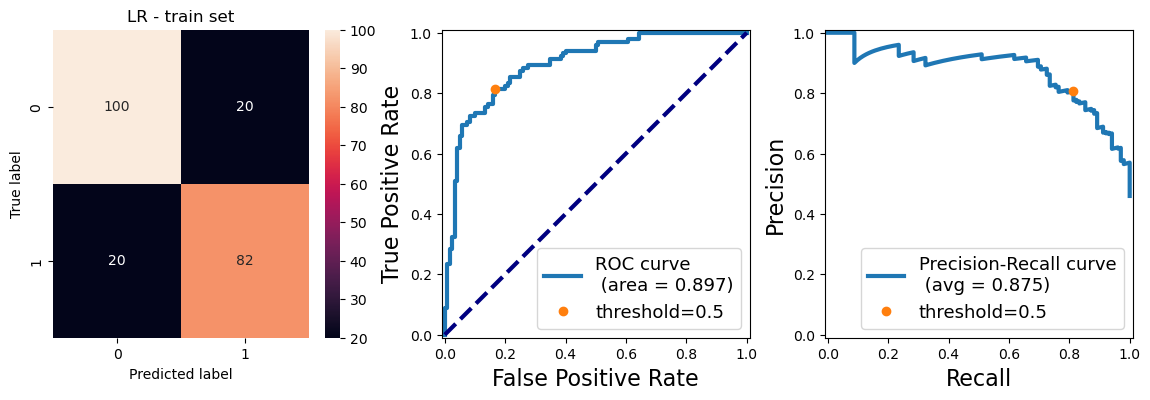

In [18]:
## showing performance on the TRAIN set
y_pred = grid_lr.predict(X_train)

confusion_mc_c = confusion_matrix(y_train, y_pred)
df_cm_c = pd.DataFrame(confusion_mc_c, index = [0,1], columns = [0,1])

fig,axes = plt.subplots(1,3,figsize=(14,4))

sns.heatmap(df_cm_c, annot=True , fmt='d' , ax = axes[0] )
axes[0].set_title('LR - train set')
axes[0].set_ylabel('True label')
axes[0].set_xlabel('Predicted label')

axes[1] = makeROCplot( X_train , y_train , grid_lr.decision_function , axes[1])

axes[2] = makePRplot( X_train , y_train , grid_lr.decision_function , axes[2])

print('accuracy         : {:.3f}'.format( accuracy_score( y_train , y_pred) ))
print('balanced accuracy: {:.3f}'.format( balanced_accuracy_score( y_train , y_pred) ))
fpr, tpr, thresholds = roc_curve(y_train, grid_lr.decision_function(X_train))
print('ROC AUC          : {:.3f}'.format(auc(fpr, tpr)))
print('average precision: {:.3f}'.format(average_precision_score( y_train , 
                                                                 grid_lr.decision_function(X_train) )))


Note that **we do not compute any metric of this model on the test set yet.**
Indeed, consider that the model you use (eg. logistic regression, decision tree, ... ) is just another hyper-parameter. 

So, we still have to compare our current model with the decision tree model and we want to do this based on the train set only. 
So by not computing anything on the test set, I make sure I won't accidentaly compare the model based in the test set instead.

Here we obtain a number of values for the train set. It is important to note that these are different from the **cross-validated score** which we obtained using the different folds.
Using the cross-validation score makes us less prone to overfitting, so this is the one which I will use when comparing the results of different grid searches.

To recap, it is important to distinguish:

In [19]:
print('{} on whole train set: {:.3f}'.format( scoreToOptimize , 
                                             roc_auc_score( y_train ,
                                                           grid_lr.decision_function(X_train) )))
print('cross-validated {}   : {:.3f}'.format( scoreToOptimize , 
                                             grid_lr.best_score_))

roc_auc on whole train set: 0.897
cross-validated roc_auc   : 0.887


The one we want to use to compare models is the second one (cross validated score). 

# decision tree classifier

In [20]:
X_train.shape

(222, 8)

In [21]:
len(X_train)//5

44

There is 222 observations, 8 variables.

Let's allow the tree depth to go from 2 to 2 times the number of variables -> 16.

We could allow the minimum size of nodes to go toward fairly large sizes, say number of samples / 5  ->44.

In [22]:
%%time
from sklearn.tree import DecisionTreeClassifier


grid_values = {'criterion': ['entropy','gini'],
               'max_depth':np.arange(2,2*X_train.shape[1]),
               'min_samples_split':np.arange(4,1+len(X_train)//5,4),
              'min_samples_leaf':np.arange(2,len(X_train)//5,4)}

grid_tree = GridSearchCV(DecisionTreeClassifier(class_weight="balanced"), 
                             param_grid = grid_values, scoring=scoreToOptimize,
                             n_jobs=-1)

grid_tree.fit(X_train, y_train)

print('Grid best parameter (max. ',scoreToOptimize,'): ', grid_tree.best_params_)
print('Grid best score (',scoreToOptimize,'): ', grid_tree.best_score_)

Grid best parameter (max.  roc_auc ):  {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 32}
Grid best score ( roc_auc ):  0.8506349206349206
CPU times: user 4.68 s, sys: 89.4 ms, total: 4.77 s
Wall time: 22.8 s


We can note here that the chosen parameters are not at the extremes of the ranges I have tested for:
 * max depth at 4 . tested from 2 to 16
 * min sample split at 10 . tested for 4 to 44
 * min sample leaves at 32. tested for 2 to 42

If you see that the best model is on the extreme of one of these range, the best is to test for a larger range.

accuracy         : 0.802
balanced accuracy: 0.802
ROC AUC          : 0.897
average precision: 0.878


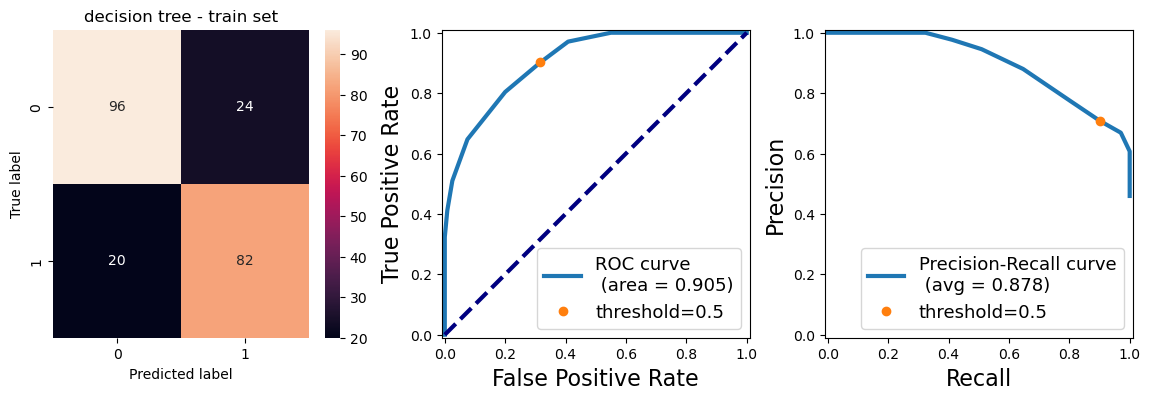

In [23]:
y_pred = grid_tree.predict(X_train)

confusion_mc = confusion_matrix(y_train, y_pred)
df_cm = pd.DataFrame(confusion_mc, index = [0,1], columns = [0,1])

fig,axes = plt.subplots(1,3,figsize=(14,4))

sns.heatmap(df_cm, annot=True , fmt='d' , ax = axes[0] )
axes[0].set_title('decision tree - train set')
axes[0].set_ylabel('True label')
axes[0].set_xlabel('Predicted label')

# the decision trees have no decision_function, 
# so we use predict_proba and extract the second column, which correspond to the predicted probability of "yes"
#
# also : applyexpit = False because we give probabilities directly here and not logit (contrary to a logistic regression)
axes[1] = makeROCplot(X_train , y_train , 
            lambda x : grid_tree.predict_proba(x)[:,1] , 
            applyExpit=False , 
            ax=axes[1])

axes[2] = makePRplot( X_train , y_train , 
                     lambda x : grid_tree.predict_proba(x)[:,1], 
                     applyExpit=False , 
                     ax=axes[2])

print('accuracy         : {:.3f}'.format( accuracy_score( y_train , y_pred) ))
print('balanced accuracy: {:.3f}'.format( balanced_accuracy_score( y_train , y_pred) ))
fpr, tpr, thresholds = roc_curve(y_train, grid_lr.decision_function(X_train))
print('ROC AUC          : {:.3f}'.format(auc(fpr, tpr)))
print('average precision: {:.3f}'.format(average_precision_score( y_train , 
                                                                 grid_tree.predict_proba(X_train)[:,1] )))

We can plot that tree:

Text(0.5, 1.0, 'best single decision tree')

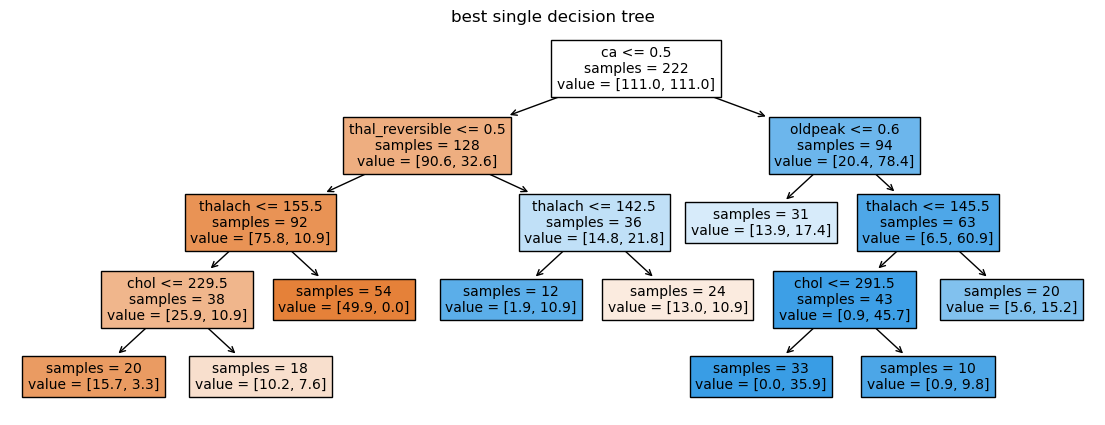

In [24]:
from sklearn.tree import plot_tree
fig,ax = plt.subplots(figsize=(14,5))
plot_tree( grid_tree.best_estimator_ , 
          feature_names=X_train.columns , 
          ax=ax , fontsize=10 , filled=True , impurity=False , precision=1)
ax.set_title('best single decision tree')

In [25]:
print('cross-validated {}   : {:.3f}'.format( scoreToOptimize , 
                                             grid_tree.best_score_))

cross-validated roc_auc   : 0.851


The resulting tree seems relatively simple (max depth 4), and the (cross-validated) roc auc on the train set is 0.851. 
This is less than what we obtained using the logistic regression (0.887).


# K-NN

In [26]:
%%time
from sklearn.neighbors import KNeighborsClassifier

grid_values_knn = {'model__n_neighbors': np.arange(2,100,1),
               'model__weights':['uniform','distance']}

pipeline_knn = Pipeline([('scaler',StandardScaler()),
                         ('model',KNeighborsClassifier(n_jobs=-1))])

grid_knn = GridSearchCV(pipeline_knn, 
                        param_grid = grid_values_knn,
                        scoring=scoreToOptimize,
                        n_jobs=-1)

grid_knn.fit(X_train, y_train)

print('Grid best parameter (max. ',scoreToOptimize,'): ', grid_knn.best_params_)
print('Grid best score (',scoreToOptimize,'): ', grid_knn.best_score_)

Grid best parameter (max.  roc_auc ):  {'model__n_neighbors': 27, 'model__weights': 'distance'}
Grid best score ( roc_auc ):  0.8949206349206349
CPU times: user 520 ms, sys: 9.6 ms, total: 529 ms
Wall time: 3.74 s


accuracy         : 1.000
balanced accuracy: 1.000
ROC AUC          : 1.000
average precision: 1.000


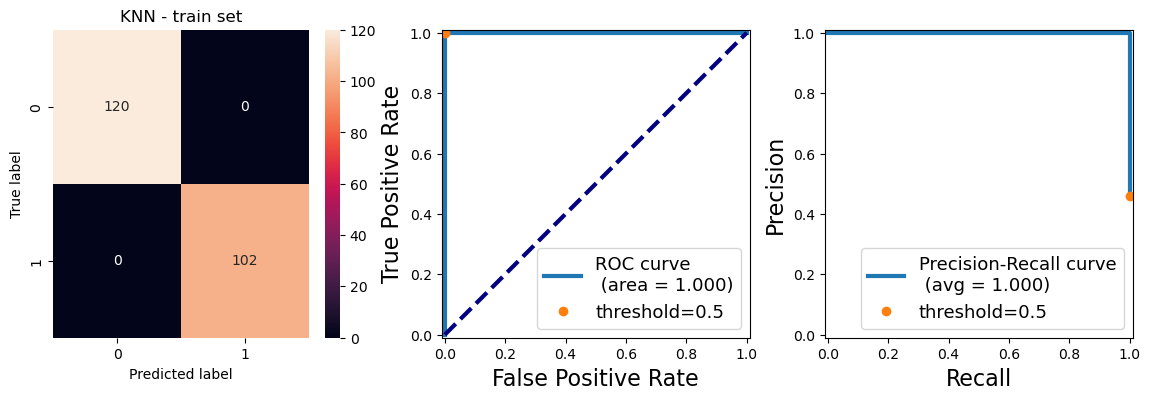

In [27]:
## showing performance on the TRAIN set
y_pred = grid_knn.predict(X_train)

confusion_mc_c = confusion_matrix(y_train, y_pred)
df_cm_c = pd.DataFrame(confusion_mc_c, index = [0,1], columns = [0,1])

fig,axes = plt.subplots(1,3,figsize=(14,4))

sns.heatmap(df_cm_c, annot=True , fmt='d' , ax = axes[0] )
axes[0].set_title('KNN - train set')
axes[0].set_ylabel('True label')
axes[0].set_xlabel('Predicted label')

# the KNN has no decision_function, 
# so we use predict_proba and extract the second column, 
#  which correspond to the predicted probability of "yes"
#
# also : applyexpit = False because we give probabilities directly here and not logit (contrary to a logistic regression)
knn_decision_function = lambda x : grid_knn.predict_proba(x)[:,1]

axes[1] = makeROCplot( X_train , y_train , 
                      knn_decision_function , 
                      applyExpit=False , 
                      ax = axes[1])

axes[2] = makePRplot( X_train , y_train , 
                     knn_decision_function ,
                     applyExpit=False ,
                     ax = axes[2])

print('accuracy         : {:.3f}'.format( accuracy_score( y_train , y_pred) ))
print('balanced accuracy: {:.3f}'.format( balanced_accuracy_score( y_train , y_pred) ))
fpr, tpr, thresholds = roc_curve(y_train, knn_decision_function(X_train))
print('ROC AUC          : {:.3f}'.format(auc(fpr, tpr)))
print('average precision: {:.3f}'.format(average_precision_score( y_train , 
                                                                 knn_decision_function(X_train) )))

Here, you can clearly see the difference between the cross-validated score and the score on the train data only.

The score on the train data only is subject to overfit, or at least gives you a overinflated confidence (here, it is 1.0).

The cross validated score (0.895) is not subject to overfit and is a better estimate of what we will get on a test set. 

# comparing the models

It is very important to know how we are going to compare our different model.

We have 3 main choices, and only 1 of these is good:

 * compare on whole train set performance : **BAD**, because it is subject to overfit
 * compare on whole test set performance : **BAD**, it is a case of leakage. basically by doing that you would increase the performance you see on your particular test set, but there would not be any guarantee this would also increase performance on some other new data (basically you risk overfitting on your test set).
 * compare on cross-validated score : **GOOD** this prevents leakage and overfit. The cross-validated score should give you a good estimate of the performance on the test set.

So in our case, we will look at the cross-validated ROC AUC:

 * logistic regression : 0.887
 * decision tree : 0.851
 * kNN : 0.895

So here, the kNN gives us the best performance.


## evaluation of the final model on the test set

now that all the hyperparameters have been set, we can (finally) evaluate our final model on the test set

In [28]:
best_pipeline = grid_knn.best_estimator_

accuracy         : 0.865
ROC AUC          : 0.938
average precision: 0.944


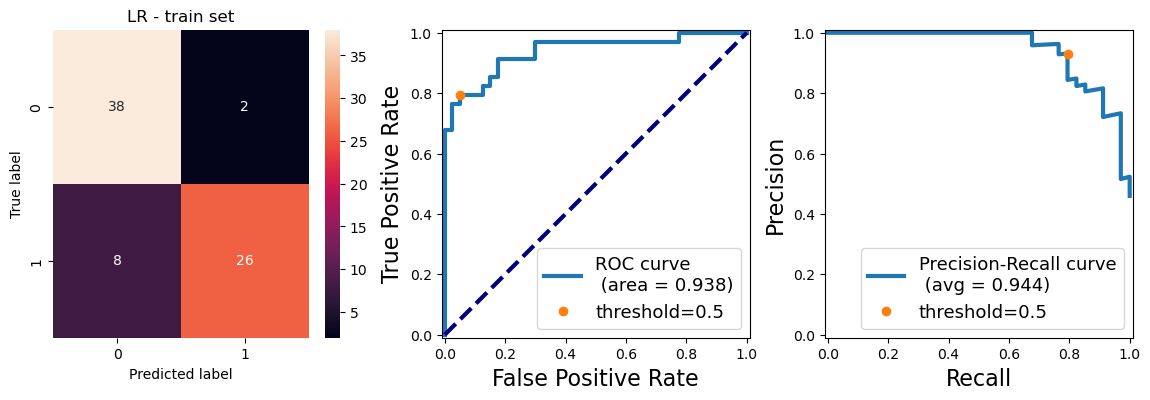

In [29]:
y_pred = best_pipeline.predict(X_test)

confusion_mc_c = confusion_matrix(y_test, y_pred)
df_cm_c = pd.DataFrame(confusion_mc_c, index = [0,1], columns = [0,1])

fig,axes = plt.subplots(1,3,figsize=(14,4))

sns.heatmap(df_cm_c, annot=True , fmt='d' , ax = axes[0] )
axes[0].set_title('LR - train set')
axes[0].set_ylabel('True label')
axes[0].set_xlabel('Predicted label')


knn_decision_function = lambda x : best_pipeline.predict_proba(x)[:,1]

axes[1] = makeROCplot( X_test , y_test ,knn_decision_function , axes[1] , applyExpit=False)
axes[1] = makePRplot( X_test , y_test , knn_decision_function , axes[2], applyExpit=False)

print('accuracy         : {:.3f}'.format( accuracy_score( y_test , y_pred) ))
fpr, tpr, thresholds = roc_curve(y_test, knn_decision_function(X_test))
print('ROC AUC          : {:.3f}'.format(auc(fpr, tpr)))
print('average precision: {:.3f}'.format(average_precision_score( y_test , knn_decision_function(X_test))))

We actually get metrics which are very comparable to what was obtained on the training set.

## ranking features 

Now, we have a small problem, because our best model, the KNN, does not have a in-built idea of feature importance: it is not a very interpretable model.

One thing we can do then is to grab the logistic model, which is slightly less performant, but very interpretable:

In [31]:
from operator import itemgetter

## the logistic regression is the second element of the pipeline : grid_lr.best_estimator_[1]
##  weights are in the .coef_ , which is a 2D matrix with 1 row, I take only the row to make it 1D : .coef_[0]

LR_weight = grid_lr.best_estimator_[1].coef_[0] ## getting the weight
LR_weight = pd.Series(LR_weight , index = coVariables.columns ) ## adding column names as index
LR_weight = LR_weight.iloc[ np.argsort( LR_weight.abs() )[::-1] ] ## sorting by absolute value in decreasing order

LR_weight

ca                 0.544032
thal_reversible    0.503614
thalach           -0.404833
oldpeak            0.333215
sex_male           0.240646
thal_defect        0.103096
chol               0.074332
age                0.067790
dtype: float64

An alternative to that, when you have a uninterpretable model, is to see how its prediction change what happens in your model when you remove a variable, or perturb it, or something similar.

There are different methods to that:
 * [permutation_importance](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance): drop in performance when one feature column is permuted
 * [SHAP](https://shap.readthedocs.io/en/latest/index.html): tries to quantify how each specific input contributes to each specific output
 * [ELI5](https://github.com/TeamHG-Memex/eli5): broader library that aggregates different algorithms such as permutation or [LIME](https://eli5.readthedocs.io/en/latest/blackbox/lime.html#eli5-lime)

A common feature these methods have is that they usually require a lot of computation, either to re-train others models, or to make prediction for perturbed data. Here for our small dataset that should be OK, but it quickly translates to hours of computations, or more...

Let's use permutation importance here. It is known that it has problems in the presence of highly correlated features, but that is not the case in this dataset.

In [32]:
%%time
from sklearn.inspection import permutation_importance

## each feature will be permuted 100 time so we have somewhat robust to stochastic effects 
permutation_results = permutation_importance(best_pipeline,X_train, y_train, n_repeats=100,
                                random_state=42)

CPU times: user 7.11 s, sys: 1.33 s, total: 8.44 s
Wall time: 13.1 s


In [33]:
# permutation_results contain a importances_mean and importances_std attribute
# which are in the same order as X_train columns
#    importances_mean: mean importance across all permutations
#    importances_std : standard deviation of the importance across all permutations

df_permutation_importances = pd.DataFrame( {'mean':permutation_results.importances_mean,
                                            'std':permutation_results.importances_std},
                                          index = X_train.columns)
df_permutation_importances.sort_values(by='mean',ascending=False)                            

,mean,std
thal_reversible,0.164414,0.017521
thalach,0.157162,0.014028
ca,0.156892,0.017447
age,0.146216,0.013490
chol,0.140676,0.012642
oldpeak,0.134144,0.013819
sex_male,0.073063,0.012670
thal_defect,0.024505,0.006381


So here you can see that the order is not exactly the same as for the logistic regression. 

There is some similarity (for example, the top 3 and bottom 3 are the same), but the role of age for example is quite different. 

The precise values themselves are not on the same scale between the permutation importances and the logistic regression coefficients. 

Last but not least, the importances do not let you know in which direction the influence of each feature goes, whereas the logistic regression coefficient do.


## Parameter interpretation


Interestingly, the variable associated with the strongest and the lowest weight is `thal` : the results of the blood flow observed via the radioactive dye.
The `'defect'` diagnostic seems uninformative, while the `'reversible'` is quite useful.

If we presume that it is not possible to drop `thal_defect` without also loosing `thal_reversible` (because they result from the same experiment), the 3 variables we could then elect to remove from our analysis would be the sex of the patient (`sex_male`), the decrease of the ST segment (`oldpeak`), and cholesterol level (`chol`).

Let's plot them to get a better feeling here :

<Axes: xlabel='sex_male', ylabel='count'>

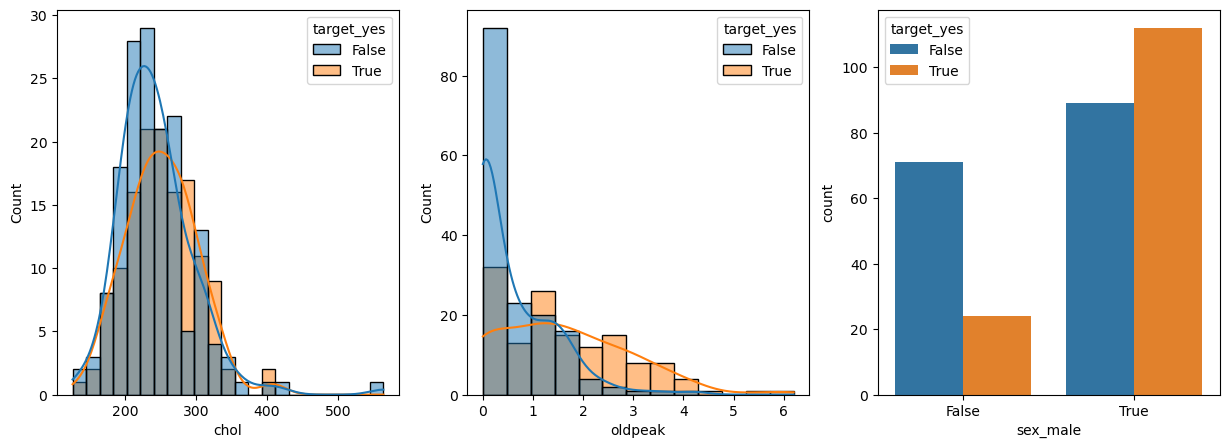

In [34]:
fig,ax = plt.subplots(1,3, figsize=(15,5))

sns.histplot( x='chol' , hue='target_yes' , kde=True , data=df ,  ax = ax[0])
sns.histplot( x='oldpeak' , hue='target_yes' , kde=True, data=df ,  ax = ax[1])
sns.countplot( x='sex_male' , hue='target_yes' , data=df ,  ax = ax[2])


Indeed, for the cholesterol levels the distributions between observations with or without a disease are quite similar.

> Note : of course, if we consider that we could lose `thal_defect` without also losing `thal_reversible`, then we would remove it and keep the cholesterol level instead


We had noted the covariables relative importance before.

On additional thing is something that cannot see with the permutation importance is the direction of the effect.

If we look at the logistic regression coefficient these appear:

In [35]:
LR_weight

ca                 0.544032
thal_reversible    0.503614
thalach           -0.404833
oldpeak            0.333215
sex_male           0.240646
thal_defect        0.103096
chol               0.074332
age                0.067790
dtype: float64

We can then see that all covariables except `thalach` are associated with a higher probability of having a heart disease (eg. being older is linked to more heart disease).

The `thalach` covariable corresponds to the maximum heart rate during the stress test. It would appear that a lower maximum heart rate during the stress test is associated with a higher probability of heart disease.


To be fully interpreted, these should be discussed with specialists, and be accompanied by an in depth review of how the data was collected.

> additionnal note of correction : when dealing with categorical variables, it is normal to have all levels EXCEPT the base one represented as columns. For instance, for the `thal` column we DO NOT WANT to have a `thal_normal` column. Including the reference level as a covariable column creates a linear dependence between the covariables (eg, `thal_normal = 1 - thal_reversible - thal_defect`). 

Finally, let's see how one could tweak this model to favor less false positive, or less false negative depending on our objectives.

This relies on the model's `.predict_proba()` function, which return a probability value for each class for each of our points : 

In [36]:
probas = best_pipeline.predict_proba(X_test)
## probability of class [no , yes] for the 1st point: 
probas[0,]

array([0.34194834, 0.65805166])

So here, the 1st point is judged to have a 0.342 probability of being a "no", and 0.658 of being a yes.

Let's look at how the probabilities fro class "yes" are distributed:

<Axes: ylabel='Count'>

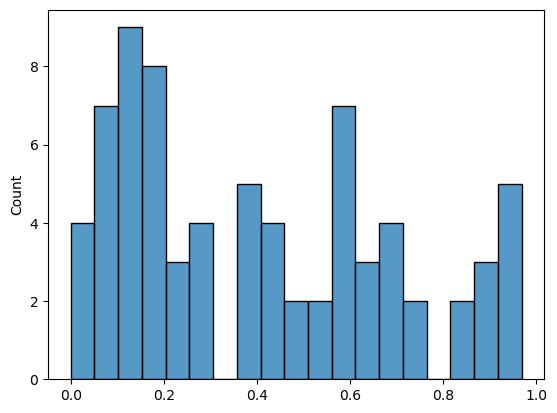

In [37]:
sns.histplot(probas[:,1], binwidth=0.05)

Ok, so this model does not gives some relatively high or very low probabilities, but many are "in between" (ie. close to the 0.5 threshold), maybe representing the cases where the model is not so sure.


So let's explore a few thesholds:

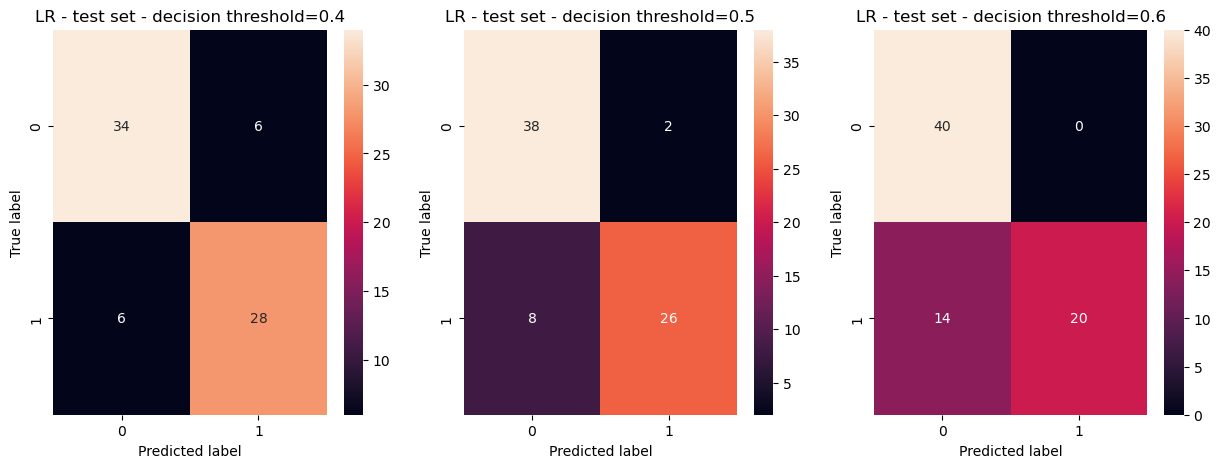

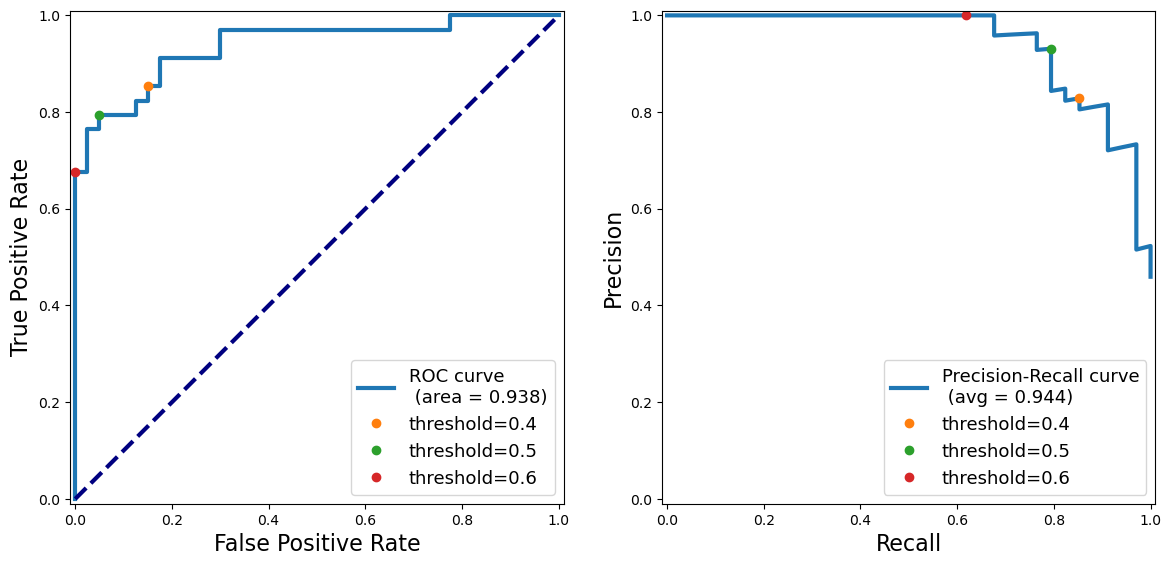

In [38]:
fig,axes = plt.subplots(1,3,figsize=(15,5))

decisionThresholds = [0.40,0.5,0.60]
for i,decisionT in enumerate(decisionThresholds):
    ## compare the probabilities of class "yes" to the threshold
    y_pred = best_pipeline.predict_proba(X_test)[:,1]>=decisionT

    confusion_mc_c = confusion_matrix(y_test, y_pred)
    df_cm_c = pd.DataFrame(confusion_mc_c, index = [0,1], columns = [0,1])

    sns.heatmap(df_cm_c, annot=True , fmt='d' , ax = axes[i] )
    axes[i].set_title('LR - test set - decision threshold='+str(decisionT))
    axes[i].set_ylabel('True label')
    axes[i].set_xlabel('Predicted label')

fig,ax = plt.subplots(1,2,figsize=(14,7))
# we make a single roc curve, where we mark the different points:
ax[0] = makeROCplot( X_test , y_test , knn_decision_function, ax[0] , applyExpit=False , dt=decisionThresholds)

# we make a single PR curve, where we mark the different points:
ax[1] = makePRplot( X_test , y_test , knn_decision_function , ax[1], applyExpit=False , dt=decisionThresholds)

So, we can see that a lower threshold (eg. 0.40) leads to a higher true postive rate, but also more false positive (eg. we miss less heart disease, but we also classify more non-diseased as diseased).

Setting the threshold higher does the converse (ie. we miss more actual heart disease).

Choosing a specific threshold can only be done with regard to your specific objectives.

One rational way to do it could be to choose a threshold such that for example your precision is at a fixed value (0.80 for instance). Note that in this case, this choice of threshold should be considered hyper-parameter tuning and be done on the train-set (it couldeven be incorporated to the gridSearch by implementing a custom scoring function).

# Bonus: playing with different metrics

Let's define a couple of additionnal scores which will be computed as well.
They will not be used to optimize the hyper-parameters, but this way they are already computed.


In [39]:
%%time
logi_r=LogisticRegression(class_weight='balanced' , solver= 'liblinear') 


pipeline_lr=Pipeline([('scalar',StandardScaler()),('model',logi_r)])


grid_values = {'model__C': np.logspace(-8,3,100),
               'model__penalty':['l1','l2']}

## we give several scores to the scoring option
## NOTE : when multiple scores are given, which score is used for the optimization is set
##        with the "refit" argument
grid_lr = GridSearchCV(pipeline_lr, 
                           param_grid = grid_values, 
                           scoring=['average_precision'  ,'roc_auc','accuracy'],
                           refit = 'average_precision' ,
                           cv=5,n_jobs=-1)

grid_lr.fit(X_train, y_train)#train your pipeline
print('grid explored')

grid explored
CPU times: user 714 ms, sys: 0 ns, total: 714 ms
Wall time: 2.8 s


Then, to retrieve the different scores, you need to delve a little in the content of the GridSearchCV object.

`grid_lr.cv_results_` is a dictionnary which contains, for each combination of parameters, scores for each folds, their average and so on.

Here are the dictionnaries keys:

In [40]:
grid_lr.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_model__C', 'param_model__penalty', 'params', 'split0_test_average_precision', 'split1_test_average_precision', 'split2_test_average_precision', 'split3_test_average_precision', 'split4_test_average_precision', 'mean_test_average_precision', 'std_test_average_precision', 'rank_test_average_precision', 'split0_test_roc_auc', 'split1_test_roc_auc', 'split2_test_roc_auc', 'split3_test_roc_auc', 'split4_test_roc_auc', 'mean_test_roc_auc', 'std_test_roc_auc', 'rank_test_roc_auc', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy'])

You can recognize a few whic are of interest:

 - 'param_model__C' : lists the value of C tested
 - 'param_model__penalty' : lists the type of penalty tested
 
and in particular, the 3 cross-validated metrics (ie. mean metric across the 5 folds):

 - 'mean_test_accuracy'
 - 'mean_test_roc_auc'
 - 'mean_test_average_precision'
 
We can the value which gave the highest average precision (ie the score given to the refit parameter) with 
`grid_lr.best_index_`


In [41]:
grid_lr.best_index_

119

In [42]:
print("best C      :" , grid_lr.cv_results_['param_model__C'][grid_lr.best_index_])
print("best penalty:" , grid_lr.cv_results_['param_model__penalty'][grid_lr.best_index_])
print('---')
print("cross-validated average precision:" , grid_lr.cv_results_['mean_test_average_precision'][grid_lr.best_index_])
print("cross-validated accuracy         :" , grid_lr.cv_results_['mean_test_accuracy'][grid_lr.best_index_])
print("cross-validated ROC AUC          :" , grid_lr.cv_results_['mean_test_roc_auc'][grid_lr.best_index_])

best C      : 0.03593813663804626
best penalty: l2
---
cross-validated average precision: 0.8769063121552698
cross-validated accuracy         : 0.7926262626262626
cross-validated ROC AUC          : 0.8868055555555555


Note that here, these measure correspond to the cross-validated score, and not to the score on the whole train set which we wre reporting before. So these values are somewhat robust to overfitting!


We can also explore the results further.

Let's put them in a dataFrame:

In [43]:
import pandas as pd


columns = ['param_model__C','param_model__penalty',
           'mean_test_accuracy','mean_test_roc_auc','mean_test_average_precision']
 
df = pd.DataFrame( {c:grid_lr.cv_results_[c] for c in columns} )
df

,param_model__C,param_model__penalty,mean_test_accuracy,mean_test_roc_auc,mean_test_average_precision
0,0.0,l1,0.540606,0.500000,0.459394
1,0.0,l2,0.801616,0.879623,0.870098
2,0.0,l1,0.540606,0.500000,0.459394
3,0.0,l2,0.801616,0.879623,0.870098
4,0.0,l1,0.540606,0.500000,0.459394
...,...,...,...,...,...
195,599.48425,l2,0.801515,0.881627,0.869866
196,774.263683,l1,0.801515,0.881627,0.869866
197,774.263683,l2,0.801515,0.881210,0.869697
198,1000.0,l1,0.801515,0.881627,0.869866


Then we could see how these metrics evolve with parameter values. For instance with accuracy:

[None]

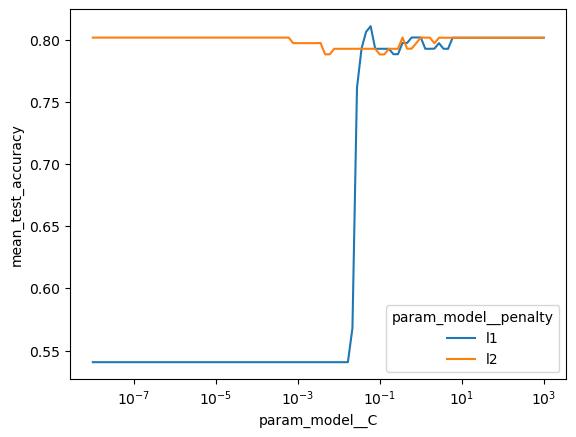

In [43]:
import seaborn as sns
ax = sns.lineplot(x = "param_model__C" , y = "mean_test_accuracy" ,
             hue = "param_model__penalty" , data = df )

ax.set(xscale='log')

We can also look at the relationship between the different scores, such as accuracy and precision:

(0.75, 0.9)

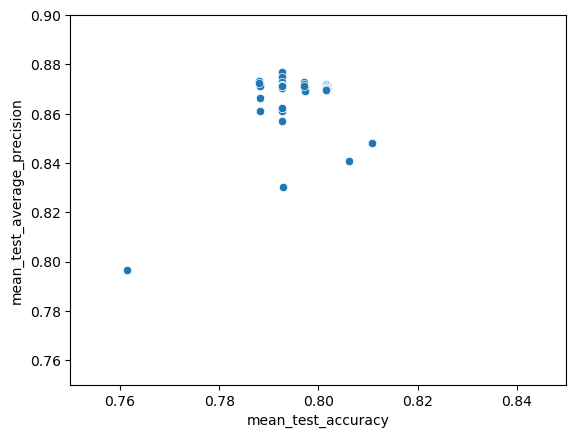

In [44]:
ax = sns.scatterplot(df , x = "mean_test_accuracy" , y = 'mean_test_average_precision')
ax.set_xlim(0.75,0.85)
ax.set_ylim(0.75,0.90)

So we can see that the best model according to average precision is different from the model with the best accuracy, but that is still has a relatively good score.

If that subject interest you, you can take a look at this [online course material](https://github.com/elzurdo/multi_objective_optimisation/tree/master).




# Bonus 2 : interpret Logistic Regression weight when you have done PCA 

Often you want to apply a PCA on your data in particular to handle correlation among features.

However, this means that now the importance or coefficient of your model (say a logistic regression) are not referring to your original features, to the PCA axes.

Let's see how we can untangle that.

In [46]:
from sklearn.decomposition import PCA

## we had a PCA to the pipeline
pipeline_lr=Pipeline([('scalar',StandardScaler()),
                      ('PCA',PCA()),
                      ('model',LogisticRegression(class_weight='balanced' , solver= 'saga') )])

# define the hyperparameters to test
grid_values = {'model__C': np.logspace(-5,2,100),
               'model__l1_ratio': np.linspace(0,1,11),
               'model__penalty':['elasticnet']}


grid_lr = GridSearchCV(pipeline_lr, 
                           param_grid = grid_values, 
                           scoring=scoreToOptimize,
                           cv=5,n_jobs=-1)

grid_lr.fit(X_train, y_train)#train your pipeline
print('grid explored')

grid explored


Our Best estimator has 3 elements : a scaler, PCA, logistic regression

In [47]:
grid_lr.best_estimator_

Pipeline(steps=[('scalar', StandardScaler()), ('PCA', PCA()),
                ('model',
                 LogisticRegression(C=0.040370172585965536,
                                    class_weight='balanced', l1_ratio=0.0,
                                    penalty='elasticnet', solver='saga'))])

If we look at the weight of the LR, they refer to the output of the PCA : the PCA axes.

In [48]:
## grab the LR
lr = grid_lr.best_estimator_[2]
lr.coef_

array([[ 0.84317971, -0.10603588, -0.28779089,  0.03684788,  0.12843785,
         0.08861834,  0.2270335 , -0.14475409]])

So, PCA axis 1 has coefficient 0.76063341,

PCA axis 2 has coefficient -0.09416307, ...

Now, the idea is that each axis of the PCA is a linear combination of our original features. So by combining the weight of each PCA axis in our regression with the weight of each feature in each PCA axis we should be able to retrieve the original feature contribution to the model.

To get the contribution of each feature to the PCA axis:

In [49]:
# grid_lr.best_estimator_[1] is our PCA
pca = grid_lr.best_estimator_[1]
pca.components_

array([[ 4.43646453e-01,  1.97112312e-01, -4.52264618e-01,
         4.59054421e-01,  4.42615567e-01,  1.43151011e-01,
         3.54059615e-01,  8.53894152e-02],
       [ 1.02582506e-01,  5.50849583e-01,  1.43363577e-01,
        -1.17193118e-01,  3.08249474e-02, -4.28767938e-01,
         1.92797066e-01, -6.55584772e-01],
       [ 3.21393698e-01,  9.48374132e-02, -2.09470023e-01,
         2.27588381e-02,  9.07270127e-03, -6.29986970e-01,
        -5.86419824e-01,  3.20097165e-01],
       [-3.19073781e-01,  6.38662584e-01,  4.22600181e-01,
         3.05903879e-01,  1.42395030e-01,  1.40923766e-01,
        -1.43244224e-01,  3.96836452e-01],
       [ 4.05955384e-02, -2.16822081e-01,  3.09082652e-01,
        -3.26037617e-01,  8.48534725e-01,  4.66600201e-03,
        -1.60715249e-01, -6.03757530e-02],
       [-4.15862703e-01, -3.76215133e-01,  6.40855613e-02,
         6.81621288e-01,  1.38890280e-01, -3.59925468e-01,
        -3.72330786e-02, -2.58036222e-01],
       [-6.33436943e-01,  2.043120

each row of this matrix corresponds to a PCA axis,

each column correspond to an original feature:

In [50]:
dfPCA = pd.DataFrame(pca.components_)
dfPCA.columns = X_train.columns
dfPCA

,age,chol,thalach,oldpeak,ca,sex_male,thal_reversible,thal_defect
0,0.443646,0.197112,-0.452265,0.459054,0.442616,0.143151,0.354060,0.085389
1,0.102583,0.550850,0.143364,-0.117193,0.030825,-0.428768,0.192797,-0.655585
2,0.321394,0.094837,-0.209470,0.022759,0.009073,-0.629987,-0.586420,0.320097
3,-0.319074,0.638663,0.422600,0.305904,0.142395,0.140924,-0.143244,0.396836
4,0.040596,-0.216822,0.309083,-0.326038,0.848535,0.004666,-0.160715,-0.060376
5,-0.415863,-0.376215,0.064086,0.681621,0.138890,-0.359925,-0.037233,-0.258036
6,-0.633437,0.204312,-0.658568,-0.276969,0.207440,-0.038114,-0.045891,-0.000765
7,0.108261,0.102637,-0.138146,0.183901,-0.021205,0.497898,-0.666140,-0.482439


So if we multiply each row by the contribution of the PCA axes to the model we get:

In [51]:
dfPCA.multiply( lr.coef_ , axis='index' ) # axis='index' make the multiplication by row and mot by column

,age,chol,thalach,oldpeak,ca,sex_male,thal_reversible,thal_defect
0,0.374074,0.166201,-0.381340,0.387065,0.373204,0.120702,0.298536,0.071999
1,-0.010877,-0.058410,-0.015202,0.012427,-0.003269,0.045465,-0.020443,0.069516
2,-0.092494,-0.027293,0.060284,-0.006550,-0.002611,0.181305,0.168766,-0.092121
3,-0.011757,0.023533,0.015572,0.011272,0.005247,0.005193,-0.005278,0.014623
4,0.005214,-0.027848,0.039698,-0.041876,0.108984,0.000599,-0.020642,-0.007755
5,-0.036853,-0.033340,0.005679,0.060404,0.012308,-0.031896,-0.003300,-0.022867
6,-0.143811,0.046386,-0.149517,-0.062881,0.047096,-0.008653,-0.010419,-0.000174
7,-0.015671,-0.014857,0.019997,-0.026620,0.003070,-0.072073,0.096426,0.069835


Then we want to sum across all axis:

In [52]:
original_axis_coef = dfPCA.multiply( lr.coef_ , axis='index' ).sum()
original_axis_coef.sort_values(key=abs, ascending=False)

ca                 0.544029
thal_reversible    0.503647
thalach           -0.404829
oldpeak            0.333241
sex_male           0.240642
thal_defect        0.103056
chol               0.074372
age                0.067823
dtype: float64

Now, if you compare with the coefficient we obtained earlier without the PCA, you see that we get the same thing:

In [53]:
LR_weight

ca                 0.544032
thal_reversible    0.503614
thalach           -0.404833
oldpeak            0.333215
sex_male           0.240646
thal_defect        0.103096
chol               0.074332
age                0.067790
dtype: float64